# Time series analyses

In [172]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss 
from datetime import date 
import holidays
import importlib

Monterrey = pd.read_csv("Files/Datos_22_24_CENTRO_limpios.csv", parse_dates=[0], index_col = "date")
daily_Monterrey = Monterrey.resample('D').mean()

## Functions

In [173]:
# Directorio de archivos
import sys
sys.path.append("Functions")

importlib.reload(Feature_Engineering)
importlib.reload(EDA)

import Feature_Engineering
import EDA

### Feature Engineering

In [174]:
from Feature_Engineering import add_holiday_feature
from Feature_Engineering import add_weekend_feature
from Feature_Engineering import add_cyclic_feature

### Exploratory time series analysis

In [175]:
from EDA import graficar_serie_tiempo
from EDA import Periodograma
from EDA import Top_10_Periodogram
from EDA import heat
from EDA import prueba_adf
from EDA import prueba_kpss

## Feature Engineering

### Holidays

In [176]:
daily_Monterrey, festivos_df = add_holiday_feature(daily_Monterrey, 2022, 2023, country='Mexico')
display(festivos_df)


,Fecha,Evento
0,2022-01-01,Año Nuevo
1,2022-02-07,Día de la Constitución
2,2022-03-21,Natalicio de Benito Juárez
3,2022-05-01,Día del Trabajo
4,2022-09-16,Día de la Independencia
5,2022-11-21,Día de la Revolución
6,2022-12-25,Navidad
7,2023-01-01,Año Nuevo
8,2023-02-06,Día de la Constitución
9,2023-03-20,Natalicio de Benito Juárez


### Weekends

In [177]:
# Crear la variable dummy para fines de semana
daily_Monterrey = add_weekend_feature(daily_Monterrey)

In [178]:
daily_Monterrey

,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR,is_holiday,is_weekend
date,,,,,,,,,,,,,,,,,
2022-01-01,1.532500,5.152917,18.902500,24.255833,25.416667,68.583333,29.173750,705.870833,0.0,24.791667,4.329167,0.146958,26.112917,5.733333,185.291667,1,1
2022-01-02,1.230000,3.760833,12.312500,16.241667,26.654167,84.875000,11.750000,716.475000,0.0,25.083333,5.183333,0.144375,14.480417,9.766667,80.166667,0,1
2022-01-03,1.197500,5.137500,12.600000,17.987500,31.666667,41.916667,7.232083,720.066667,0.0,24.958333,3.546250,0.145375,9.794583,9.208333,77.500000,0,0
2022-01-04,1.743333,20.233333,37.887500,58.308333,18.375000,76.000000,30.655417,714.470833,0.0,30.416667,5.975000,0.139417,12.896667,4.737500,171.333333,0,0
2022-01-05,1.656250,15.480000,36.303750,51.986667,25.095833,88.120833,27.819458,710.172083,0.0,24.270833,7.105000,0.149083,19.871875,6.280000,167.629167,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,0.695833,6.058333,14.054167,20.350000,36.916667,63.791667,33.291667,710.625000,0.0,67.166667,2.741667,0.292333,25.658333,7.050000,59.583333,0,1
2024-07-28,0.560833,3.445833,8.666667,12.358333,25.041667,42.541667,20.000000,711.070833,0.0,68.583333,2.604167,0.166375,26.092500,7.641667,78.125000,0,1
2024-07-29,0.613333,4.966667,10.245833,15.445833,20.833333,50.291667,22.101667,711.429167,0.0,65.875000,2.629167,0.230417,27.005417,8.633333,122.583333,0,0


## PM 10

### Correlation dependent variables with independent ones

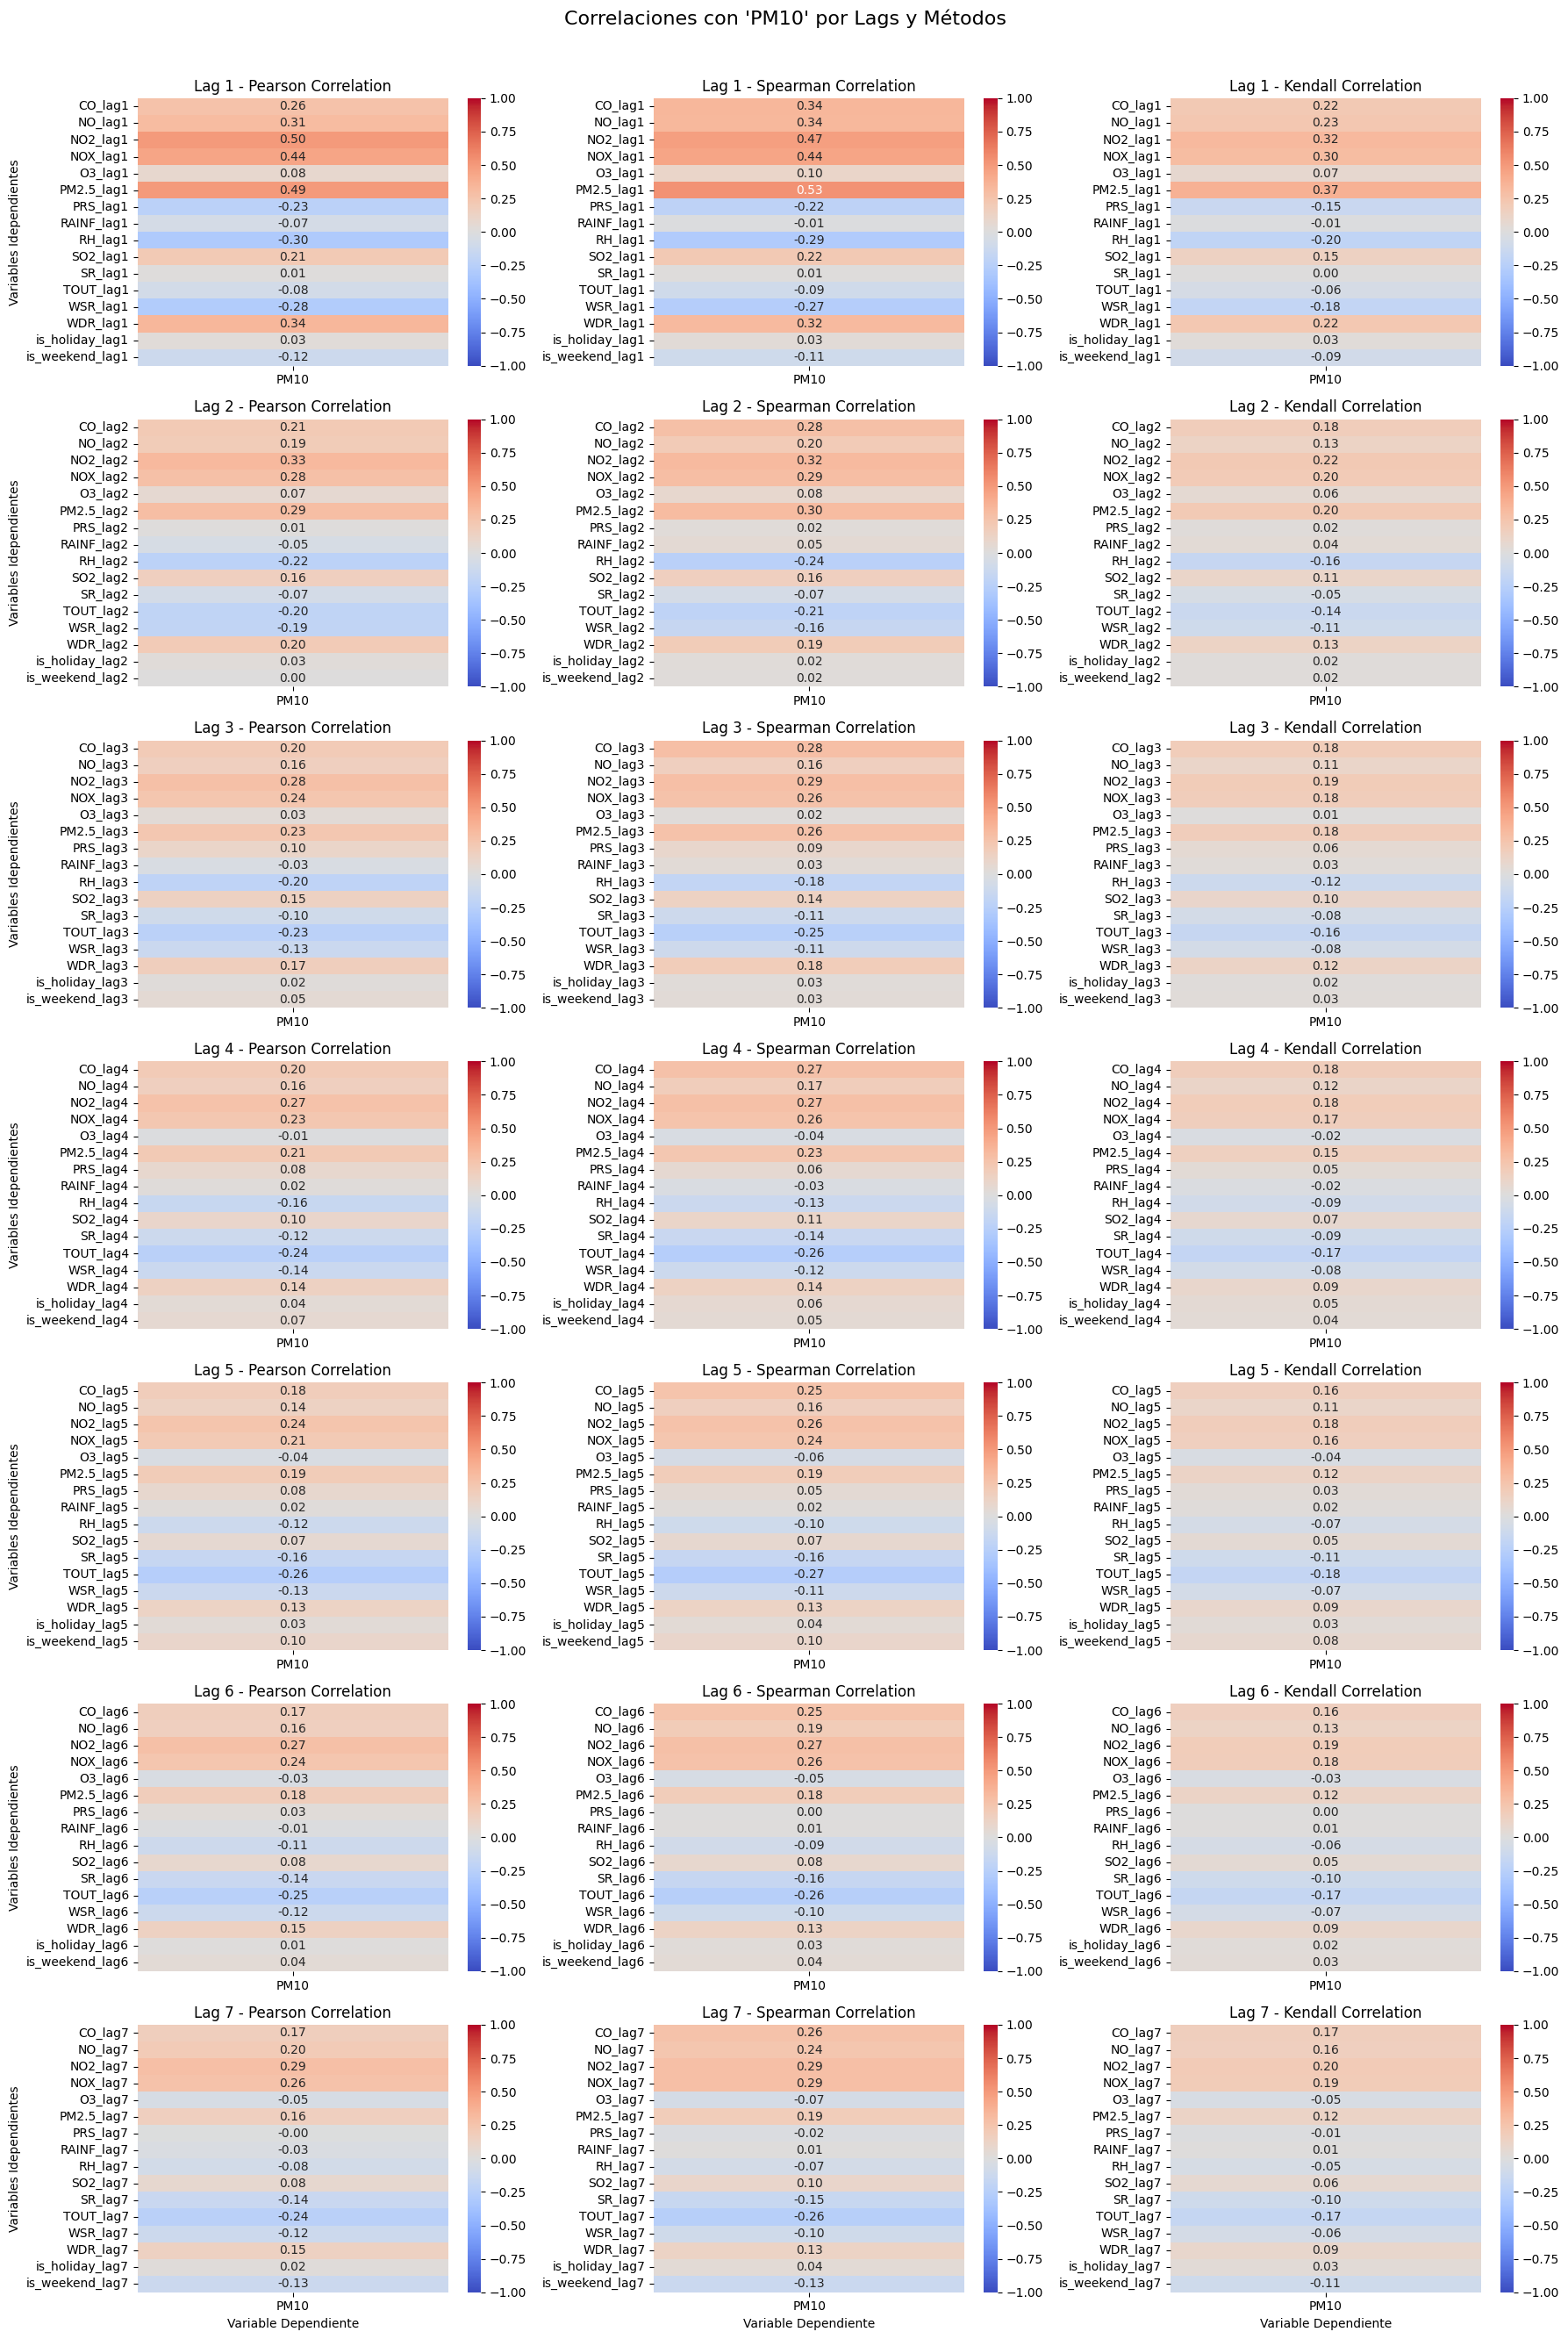

In [179]:
heat(daily_Monterrey, "PM10", 7)

### Stationarity test

In [180]:
prueba_adf(daily_Monterrey["PM10"])

-- ADF a nivel --
Estadístico ADF: -7.239542273265946
Valor p: 1.900198380711834e-10
Valores Críticos:
La serie SI es estacionaria a nivel (rechazamos la hipótesis nula).

-- ADF de tendencia --
Estadístico ADF: -7.240204381014418
Valor p: 4.0174323672875075e-09
Valores Críticos:
La serie SI es estacionaria a nivel y tendencia (rechazamos la hipótesis nula).


In [181]:
prueba_kpss(daily_Monterrey["PM10"])

-- KPSS a nivel --
Estadístico KPSS: 0.18351252280507896
Valor p: 0.1
Valores Críticos:
La serie SI es estacionaria a nivel (no rechazamos la hipótesis nula).

-- KPSS de tendencia --
Estadístico KPSS: 0.175597591980159
Valor p: 0.025335340016534154
Valores Críticos:
La serie NO es estacionaria a tendencia (rechazamos la hipótesis nula).


c:\Users\José Antonio\Documents\TEC\Python\Multivariados\Functions\EDA.py:275: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




### identify Seasonality

c:\Users\José Antonio\Documents\TEC\Python\Multivariados\Functions\EDA.py:146: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



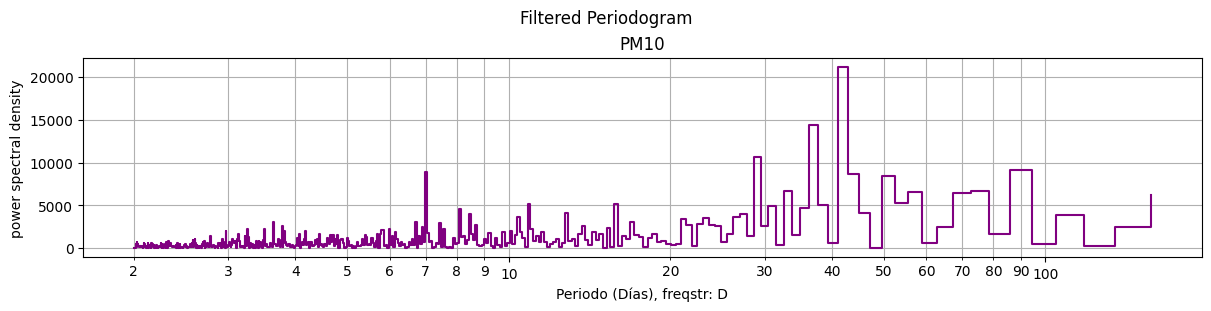

In [182]:
list_periods_spectra = Periodograma(daily_Monterrey["PM10"], detrend="constant")

In [183]:
Top_10_Periodogram(daily_Monterrey, "PM10", list_periods_spectra)


Top 10 para la variable 'PM10':


,top_periods,top_spectra
0,41.000000,21156.229784
1,36.269231,14425.607741
2,28.575758,10683.705775
3,85.727273,9099.050482
4,6.985185,8863.291258
5,42.863636,8679.481771
6,49.631579,8474.386426
7,32.517241,6703.226933
8,72.538462,6671.700546
9,55.470588,6550.979177


### Generate features to capture seasonality

In [184]:
daily_Monterrey_pm10 = add_cyclic_feature(daily_Monterrey, "2022-01-03", 41, column_name="is_41_day_cycle")

### Plot everything generated and variable to predict

In [187]:
graficar_serie_tiempo(daily_Monterrey_pm10, "PM10", ["is_holiday", "is_weekend", "is_41_day_cycle"])

## SO2

## CO

In [ ]:
Monterrey_CO = daily_Monterrey[["CO", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

In [ ]:
Monterrey_CO

,CO,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
date,,,,,,,,,
2022-01-01,1.532500,705.870833,0.0,24.791667,4.329167,0.146958,26.112917,5.733333,185.291667
2022-01-02,1.230000,716.475000,0.0,25.083333,5.183333,0.144375,14.480417,9.766667,80.166667
2022-01-03,1.197500,720.066667,0.0,24.958333,3.546250,0.145375,9.794583,9.208333,77.500000
2022-01-04,1.743333,714.470833,0.0,30.416667,5.975000,0.139417,12.896667,4.737500,171.333333
2022-01-05,1.656250,710.172083,0.0,24.270833,7.105000,0.149083,19.871875,6.280000,167.629167
...,...,...,...,...,...,...,...,...,...
2024-07-27,0.695833,710.625000,0.0,67.166667,2.741667,0.292333,25.658333,7.050000,59.583333
2024-07-28,0.560833,711.070833,0.0,68.583333,2.604167,0.166375,26.092500,7.641667,78.125000
2024-07-29,0.613333,711.429167,0.0,65.875000,2.629167,0.230417,27.005417,8.633333,122.583333


## NOX

In [ ]:
Monterrey_NOX = daily_Monterrey[["NOX", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

## NH3

## Plot decomposition time series if it in needed

In [ ]:
""" 
# Descomposición estacional de la serie temporal
seasonal_monterrey_pm10 = seasonal_decompose(daily_Monterrey["PM10"], model='additive', period=4)

# Obtener la figura generada por la descomposición
fig = seasonal_monterrey_pm10.plot()

# Ajustar el tamaño de la figura
fig.set_size_inches(12, 8)  # Cambia (12, 8) por las dimensiones deseadas

# Mostrar el gráfico
plt.show()
"""